Oppgave 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import random

In [3]:
# Oppgave 1a)

def create_grid(N, M):
    grid = np.zeros((N, N), dtype=int)
    indices = [(i, j) for i in range(N) for j in range(N)]
    random_monomer_indices = random.sample(indices, 2 * M)
    monomers = [m for m in range(-M, M + 1) if m != 0]
    for monomer, index in zip(monomers, random_monomer_indices):
        grid[index] = monomer
    return grid

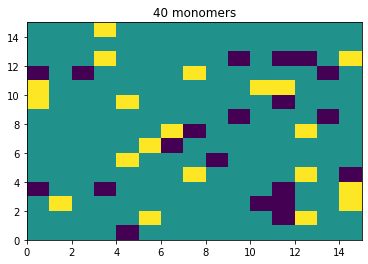

In [4]:
# Oppgave 1b)

def show_monomers(grid, M):
    """
    Input is the grid (grid) as well as the number of monomers (M).
    """
    plt.figure(1)
    plt.pcolormesh(np.sign(grid)[::-1,])
    plt.title(f"{2*M} monomers")
    plt.show()

N = 15
M = 20
grid = create_grid(N, M)
show_monomers(grid, M)

In [5]:
# Oppgave 1c)

@njit
def neighbor_coordinates(N, i, j):
    neighbors = (((i - 1) % N, j), (i, (j - 1) % N), ((i + 1) % N, j), (i, (j + 1) % N))
    return neighbors

In [7]:
# Oppgave 1d)

ε_r = 78  # [1] Relative permittivity
ε_0 = 8.85418782e-12  # [m^-3 kg^-1 s^4 A^2] vacuum permittivity
a = 23e-6  # [m] Distance between grid points (23 microns)
e = 1.60217662e-19  # [C]
α = e ** 2 / (4 * np.pi * ε_r * ε_0 * a ** 2)

@njit
def calc_relative_energy(grid):
    N = len(grid)
    monomer_indices = np.where(grid != 0)
    relative_energy = 0

    for monomer_index in zip(*monomer_indices):
        monomer = grid[monomer_index]
        for neighbor_coord in neighbor_coordinates(N, *monomer_index):
            neighbour_monomer = grid[neighbor_coord]
            if neighbour_monomer != monomer and neighbour_monomer != 0:  # i.e. not the same type or solvent
                relative_energy += np.sign(monomer) * np.sign(neighbour_monomer)

    return relative_energy
print(calc_relative_energy(grid))

-2


In [ ]:
# Oppgave 1 e)

@njit
def move_random_polymer(grid, M, is_illegal_move, move_polymer):
    random_polymer, random_direction = choose_random_legal_move(grid, M, is_illegal_move)
    return move_polymer(grid, random_polymer, random_direction)


@njit
def illegal_move(grid, monomer, direction):
    N = len(grid)
    monomer_location = np.where(grid == monomer)
    return grid[(monomer_location[0][0] + direction[0]) % N, (monomer_location[1][0] + direction[1]) % N] != 0

@njit
def move_monomer(grid, monomer, direction):
    N = len(grid)
    new_grid = np.copy(grid)
    monomer_location = np.where(grid == monomer)
    new_grid[monomer_location[0][0], monomer_location[1][0]] = 0
    new_grid[(monomer_location[0][0] + direction[0]) % N, (monomer_location[1][0] + direction[1]) % N] = monomer
    return new_grid

@njit
def do_nothing(*args): pass

@njit
def choose_random_polymer(M):
    a = np.random.randint(-M, M)
    while not a:
        a = np.random.randint(-M, M)
    return a


directions = np.array([[-1, 0], [0, -1], [1, 0], [0, 1]])
@njit
def choose_random_direction():
    i = np.random.randint(0, 4)
    return directions[i]

@njit
def choose_random_legal_move(grid, M, is_illegal_move=illegal_move):
    random_monomer = choose_random_polymer(M)
    random_direction = choose_random_direction()
    while is_illegal_move(grid, random_monomer, random_direction):
        random_monomer = choose_random_polymer(M)
        random_direction = choose_random_direction()
    return random_monomer, random_direction

@njit
def monte_carlo(grid, N_s, M, T, n=0, t_equil=np.inf, t_r=np.inf,
                is_illegal_move=illegal_move, move_polymer=move_monomer, on_iteration=do_nothing):
    epsilon = np.zeros(N_s)
    beta = 1 / (T * 1.380649e-23) * α / 2

    cluster_sizes = np.zeros(n)
    measure_index = 0

    for t in range(N_s):
        rel_energy = calc_relative_energy(grid)

        new_grid = move_random_polymer(grid, M, is_illegal_move, move_polymer)
        new_rel_energy = calc_relative_energy(new_grid)

        if new_rel_energy < rel_energy or thermal_fluctuation(new_rel_energy, rel_energy, beta):
            grid = new_grid
            rel_energy = new_rel_energy

        epsilon[t] = rel_energy

        if should_measure(t, t_equil, t_r):
            _, d = get_cluster_grid(grid)
            cluster_sizes[measure_index] = 2 * M / d
            measure_index += 1

        if t % 100 == 1:
            on_iteration(grid, epsilon[:t])

    if t_r == np.inf:
        return grid, epsilon, 0

    return grid, epsilon, np.mean(cluster_sizes[:measure_index])